In [4]:
import torch 

from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize, Lambda, ToPILImage
from torchvision.transforms.functional import to_pil_image

import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F

import matplotlib.animation as animation

from tqdm import tqdm

import math

# Key variables

In [5]:
BATCH_SIZE = 32

IMG_SIZE = 128

T = 4000

device = torch.device('cuda')

# Data preparation

In [6]:
dataset = ImageFolder('ganyu/', Compose([Resize((IMG_SIZE, IMG_SIZE)), ToTensor(), Lambda(lambda t: (t * 2) - 1)]))

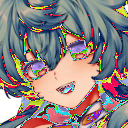

In [7]:
to_pil_image(dataset[np.random.randint(0, len(dataset))][0])

In [8]:
dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=True, drop_last=True)

# Funcs

In [9]:
def get_alpha_bar(s = 0.08):
    f = lambda t: np.cos((t + s) / (1 + s) * np.pi/2)**2
    
    return torch.tensor([f((t+1) / T)/f(0) for t in range(T)], device=device, dtype=torch.float32)

In [10]:
def get_betas_from_alpha_bar(max_beta = 0.999, s = 0.08):
    f = lambda t: np.cos((t + s) / (1 + s) * np.pi/2)**2

    betas = []
    for t in range(T):
        t1 = t / T
        t2 = (t + 1) / T
        
        betas.append(min(1 - f(t2)/f(t1), max_beta))

    return torch.tensor(betas, device=device)

In [11]:
def get_index(vals, t, tensor_shape):
    t_batch_size = t.shape[0]

    out = vals.gather(-1, t)
    
    return out.reshape(t_batch_size, *((1,) * (len(tensor_shape) - 1))).to(device)

In [12]:
alpha_bar = get_alpha_bar()

alpha_bar_prev = F.pad(alpha_bar[:-1], (1, 0), value=1.0)

betas = get_betas_from_alpha_bar()

alphas = 1. - betas

posterior_variance = betas * (1. - alpha_bar_prev) / (1. - alpha_bar)

sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

sqrt_alphas_cumprod = torch.sqrt(alpha_bar)

sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alpha_bar)

In [13]:
def forward_diffusion(x0, t):

    sqrt_alphas_cumprod_t = get_index(sqrt_alphas_cumprod, t, x0.shape).to(device)
    sqrt_one_minus_alphas_cumprod_t = get_index(sqrt_one_minus_alphas_cumprod, t, x0.shape).to(device)
    
    eps = torch.randn_like(x0.float()).to(device)

    return sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * eps, eps

# Model 

In [17]:
class UNetDownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()

        self.time_emb = nn.Linear(time_emb_dim, out_channels)
        self.relu = nn.ReLU()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(out_channels)
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(4, out_channels),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.GroupNorm(4, out_channels),
        )

        self.downsample = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 4, 2, 1)
        )


    def forward(self, x, t):
        time_emb = self.relu(self.time_emb(t))

        time_emb = time_emb.reshape([time_emb.shape[0], time_emb.shape[1], 1, 1])

        x = self.conv_layer1(x)
        
        x = x + time_emb

        x = self.conv_layer2(x)

        x = self.downsample(x)

        return x

In [18]:
class UNetUpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()

        self.time_emb = nn.Linear(time_emb_dim, out_channels)
        self.relu = nn.ReLU()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.GroupNorm(4, out_channels),
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.GroupNorm(4, out_channels),
        )

        self.resize_conv = nn.Sequential(
            nn.ConvTranspose2d(out_channels, out_channels, 4, 2, 1)
        )
        

    def forward(self, x, t):

        time_emb = self.relu(self.time_emb(t))

        time_emb = time_emb.reshape([time_emb.shape[0], time_emb.shape[1], 1, 1])

        x = self.conv_layer1(x)

        x = x + time_emb

        x = self.conv_layer2(x)

        x = self.resize_conv(x)

        return x

In [19]:
class PositionalEmbedding(nn.Module):
    def __init__(self, dim, n=10000):
        super().__init__()
        self.dim = dim
        self.n = n

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(self.n) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings

In [20]:
class UNet(nn.Module):
    def __init__(self, unet_channels=[64, 128, 256, 512, 1024], time_emb_dim=128):
        super().__init__()

        self.time_emb = nn.Sequential(
            PositionalEmbedding(dim=time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        self.conv0 = nn.Conv2d(3, unet_channels[0], 3, 1, 1)

        self.down_convs = nn.ModuleList(UNetDownBlock(unet_channels[i], unet_channels[i+1], time_emb_dim) \
                                       for i in range(len(unet_channels) - 1))

        self.up_convs = nn.ModuleList(UNetUpBlock(unet_channels[i], unet_channels[i-1], time_emb_dim) \
                                     for i in range(len(unet_channels) - 1, 0, -1))

        self.out = nn.Conv2d(unet_channels[0], 3, 1)

    
    def forward(self, x, timestep):
        t = self.time_emb(timestep)

        x = self.conv0(x)

        residuals = []

        for d_conv in self.down_convs:
            x = d_conv(x, t)
            residuals.append(x)

        for u_conv in self.up_convs:
            res = residuals.pop()
            x = torch.add(x, res)
            x = u_conv(x, t)
        
        return self.out(x)

In [21]:
def get_x_tm1(model, t, xt):
    betas_t = get_index(betas, t, xt.shape)

    sqrt_one_minus_alphas_cumprod_t = get_index(sqrt_one_minus_alphas_cumprod, t, xt.shape)
    
    sqrt_recip_alphas_t = get_index(sqrt_recip_alphas, t, xt.shape)

    model_mean = sqrt_recip_alphas_t * (
        xt - betas_t * model(xt, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index(posterior_variance, t, xt.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(xt)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

In [22]:
def show_tensor_image(image):
    
    reverse_transforms = Compose([
        Lambda(lambda t: (t + 1) / 2),
        Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        Lambda(lambda t: t * 255.),
        Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
        ToPILImage(),
    ])

    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

In [23]:
@torch.no_grad()
def generate_prev(model, n_imgs=1):
    plt.figure(figsize=(3, 3))

    x_tm1 = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device, dtype=torch.float32)

    for i in range(T-1, -1, -1):
        x_tm1 = get_x_tm1(model, torch.tensor([i]).to(device), x_tm1).to(torch.float32)
        x_tm1 = torch.clamp(x_tm1, -1.0, 1.0)

    show_tensor_image(x_tm1)
    plt.axis('off')
    plt.show()    

# Model training

In [24]:
def train_func(model, optimizer, dataloader, criterion, epochs, scheduler=None):
    results = {
        "loss" : [],
        "avg_epoch_loss" : [],
        "model_state" : model.state_dict()
    }

    for epoch in range(epochs):
        epoch_loss = 0

        with tqdm(dataloader, unit="batch") as tepoch:
            for step, batch in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch+1}")

                img_tensor = batch[0].to(device=device, dtype=torch.float32)

                t = torch.randint(0, T, (BATCH_SIZE,)).long().to(device)
                noised_img, noise = forward_diffusion(img_tensor, t)

                logits = model(noised_img, t)

                loss = criterion(logits, noise)

                epoch_loss += loss.item()

                #results["loss"].append(loss.item())
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if scheduler is not None:
                    scheduler.step(loss)
                
                tepoch.set_postfix(loss=loss.item(), \
                                    avg_loss=epoch_loss/(step+1))                

            #results["avg_epoch_loss"].append(epoch_loss/(step+1))

        if epoch % 15 == 0:
            generate_prev(model)
    
    return results

In [25]:
model = UNet().to(device)

In [26]:
sum(p.numel() for p in model.parameters())

81533379

In [62]:
optimizer = AdamW(model.parameters(), lr=1e-6)
criterion = nn.SmoothL1Loss()

Epoch 1: 100%|██████████| 26/26 [00:07<00:00,  3.45batch/s, avg_loss=0.00716, loss=0.00539]


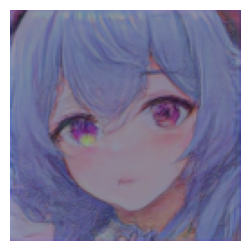

In [64]:
results = train_func(model, optimizer, dataloader, criterion, 1)

In [30]:
@torch.no_grad()
def get_sample(model):
    sample = []
    reverse_transforms = Compose([
        Lambda(lambda t: (t + 1) / 2),
        Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        Lambda(lambda t: t * 255.),
        Lambda(lambda t: t.cpu().numpy().astype(np.uint8)),
        ToPILImage(),
    ])

    x_tm1 = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device, dtype=torch.float32)

    for i in range(T-1, -1, -1):
        x_tm1 = get_x_tm1(model, torch.tensor([i]).to(device), x_tm1).to(torch.float32)
        x_tm1 = torch.clamp(x_tm1, -1.0, 1.0) 
        
        sample.append(reverse_transforms(x_tm1.squeeze()))

    return sample

In [58]:
samples = get_sample(model)

In [59]:
imgs_for_gif = samples[2000:3500:15] + samples[3500::5]

MovieWriter ffmpeg unavailable; using Pillow instead.


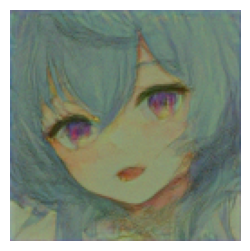

In [60]:
fig = plt.figure(figsize=(3, 3))
ims = []
for i in range(len(imgs_for_gif)):
    im = plt.imshow(imgs_for_gif[i], animated=True)
    plt.axis('off')
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims + [ims[-1]] * 200, interval=1, blit=False, repeat_delay=50000)
animate.save('diffusion.gif')
plt.show()

In [61]:
torch.save(results['model_state'], "result_v.pt")

In [54]:
model.load_state_dict(torch.load('result_v.pt'))

<All keys matched successfully>